In [2]:
from tqdm import tqdm_notebook as tqdm
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [4]:
import pickle as pkl
data = pkl.load(open('favorited_dict3.p', 'rb'))
max_item, max_user = pkl.load(open('useful_stats3.p', 'rb'))
visual_data = pkl.load(open('id_feature_dict_with_artist3_2.p', 'rb'))

In [5]:
artist_dict = pkl.load(open('artist_dict3.p', 'rb'))
item_to_artist = pkl.load(open('item_to_artist3.p', 'rb'))

In [6]:
dd_dict = pkl.load(open('dd_dict3.p', 'rb'))


In [7]:
time_dict = pkl.load(open('time_dict3.p', 'rb'))

In [42]:
img_nfavs_dict = pkl.load(open('img_nfavs3.p', 'rb'))



In [270]:
cat_dict = pkl.load(open('cat_dict3.p', 'rb'))

In [8]:
removed_items = set()
for key in range(max_item):
    if key not in visual_data:
        removed_items.add(key)
    else:
        if not isinstance(visual_data[key][0], np.ndarray) or not time_dict[key]: 
            removed_items.add(key) # for some reason, these are floats. just remove them.

In [9]:
from collections import OrderedDict

for key, value in list(artist_dict.items()):
    artist_dict[key] = list(OrderedDict.fromkeys(value))


In [10]:
for item in removed_items:
    artist = item_to_artist[item]
    artist_dict[artist].remove(item)

In [11]:
for user in data:
    rated_items = data[user]
    removed = []
    for item in rated_items:
        if item in removed_items:
            removed.append(item)
    for item in removed:
        rated_items.remove(item)
    data[user] = rated_items

In [12]:
for key, value in list(artist_dict.items()):
    if not value:
        artist_dict.pop(key)

In [13]:
users_to_remove = []
for user in data:
    images = np.unique(data[user]).tolist()
    images = [image for image in images if image in visual_data]
    if not images: users_to_remove.append(user)
    else: data[user] = images

for user in users_to_remove:
    data.pop(user)

In [14]:
for key in visual_data:
    visual_data[key] = visual_data[key][0]

In [15]:
def create_validation(data):
    valid = {}
    for key in data:
        rated_items = data[key]
        if len(rated_items) > 1:
            valid[key] = np.random.choice(rated_items)
        else:
            valid[key] = None
    return valid

In [16]:
valid = create_validation(data)

In [17]:
def sample_triple(data, valid, nSamples=1):
    samples = np.zeros((nSamples, 3), dtype=int)
    keys = list(data.keys())
    users = np.random.choice(keys, nSamples) 
    samples[:, 0] = users
    
    for i, user in enumerate(tqdm(users)):
        rated_items = data[user]
        valid_item = valid[user]
        unrated_item = np.random.choice(max_item)
        while unrated_item in rated_items or unrated_item in removed_items or unrated_item == valid_item:
            unrated_item = np.random.choice(max_item)
            
        rated_item = np.random.choice(rated_items)
        while rated_item == valid_item:
            rated_item = np.random.choice(rated_items)

        samples[i, 1] = rated_item
        samples[i, 2] = unrated_item
            
    return samples


In [18]:
import math

def sigmoid(x):
    try:
        if type(x) in (int, float, np.float64):
            return 1 / (1 + math.exp(-x))
        else:
            if len(x) == 1:
                x = np.squeeze(x)
                return 1 / (1 + math.exp(-x))
            else:
                return 1 / (1 + np.exp(-x))
    except OverflowError:
        return 0

In [19]:
def sample_assignment_triple(data, valid, batch_size=5):
    keys = list(data.keys())
    vals = [data[key] for key in keys]
    all_items = [item for sublist in vals for item in sublist]
    users_list = [[key]*len(data[key]) for key in keys]
    all_users = [item for sublist in users_list for item in sublist]
    samples = np.zeros((len(all_items)*batch_size, 3), dtype=int)

    samples[:,0] =  np.repeat(all_users, batch_size)
    samples[:,1] =  np.repeat(all_items, batch_size)
    
    for i, user in enumerate(tqdm(all_users)):
        rated_items = data[user]
        valid_item = valid[user]
        unrated_item = np.random.choice(max_item)
        while unrated_item in rated_items or unrated_item in removed_items or unrated_item == valid_item:
            unrated_item = np.random.choice(max_item)
        samples[i,2] = unrated_item

    return samples




In [682]:
assign_samples = sample_assignment_triple(data, valid, batch_size=3)


In [790]:
#hyperparameters
k=3
n=1
lr = 0.00000005
lr2 = 0.00000005
lam_u = .0
lam_bias = .0
lam_rated = .0
lam_unrated = .0
lam_vf = .0
lam_E = .0
lam_vu = .0
lam_smooth = .0
lam_dd = 0
lam_artist = .0
lam_cat = .0

sf = 1

nExpertise = 5

In [808]:
'''''initialize assignments'''

import math

artist_assignments = {}
nArtists = len(artist_dict)
for i,key in enumerate(artist_dict):
    level = i*nExpertise//nArtists
    artist_assignments[key] = level

In [23]:
all_artists = np.unique(list(item_to_artist.values()))

In [766]:
item_biases = np.random.normal(size=max_item)
latent_items = np.random.normal(size=(max_item, k), scale=0.1)
latent_users = np.random.normal(size=(max_user, k), scale=0.1)
visual_users = np.random.normal(size=(max_user, n), scale=0.1)
E = np.random.normal(size=(4096, n, nExpertise))
visual_bias = np.random.normal(size=(4096, nExpertise), scale=0.1)
dd_bias = [0]*nExpertise
artist_bias = dict(zip(all_artists, np.zeros(len(all_artists))))
category_bias = [0]*(max(cat_dict.values())+1)

item_biases_one = item_biases
latent_items_one = latent_items
latent_users_one = latent_users
visual_users_one = visual_users
E_one = E
vb_one = visual_bias
dd_one = dd_bias

item_biases_two = item_biases
latent_items_two = latent_items
latent_users_two = latent_users
visual_users_two = visual_users
E_two = E
vb_two = visual_bias
dd_two = dd_bias

item_biases = item_biases_two
latent_items = latent_items_two
latent_users = latent_users_two
visual_users = visual_users_two
E = np.repeat(E_two, nExpertise, axis=2)
visual_bias = np.repeat(vb_two, nExpertise, axis=1)
dd_bias = dd_two*nExpertise



In [807]:
'''n=5, k=5'''

item_biases = item_biases3
latent_items = latent_items3
latent_users = latent_users3
visual_users = visual_users3
#E = np.repeat(E3, nExpertise, axis=2)
E = E3.reshape((4096, 1))
E_delta = np.zeros(shape=(4096, n, nExpertise))
#visual_bias = np.repeat(visual_bias3, nExpertise, axis=1)
visual_bias = visual_bias3.reshape((4096))
vb_delta = np.zeros(shape=(4096, nExpertise))
dd_bias = dd_bias3*nExpertise
artist_bias = artist_bias3
#category_bias = category_bias3 


In [810]:
pkl.dump((item_biases3, latent_items3, latent_users3, visual_users3, E3, visual_bias3, dd_bias3),
        open('VBPR1M.pkl', 'wb'))

In [25]:
import tensorflow as tf

In [799]:
#TODO: don't repeat rated calculations

def get_assignment_objective(full_samples, batch_size=200):
    objectives = {}
    #assert batch_size % 5 == 0, "Batch size must be a multiple of 5!" #TODO: should use batchsize from above fcn
        
    n_samples = len(full_samples)
    start = 0; end = start + batch_size
    pbar = tqdm(total = len(full_samples)/batch_size)

    # Define Tensorflow graph
    tf.reset_default_graph()
    vis_data = tf.placeholder(tf.float32, shape=(None, 4096))
    user = tf.placeholder(tf.float32, shape=(None, n))
    
    visual_bias_tensor = tf.convert_to_tensor(vb_delta, dtype=tf.float32)
    E_tensor = tf.convert_to_tensor(E_delta, dtype=tf.float32)

    
    encoded = tf.einsum('kji,lk->ijl', E_tensor, vis_data)
    visual_interaction = tf.einsum('ij,kji->ik', user, encoded)

    vis_bias = tf.matmul(vis_data, visual_bias_tensor)
    obj = visual_interaction + vis_bias
    
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    old_item = -1 
    
    while start < n_samples:
        end = min(end, n_samples)
        samples = full_samples[start:end]

        rated_artist = [item_to_artist[x] for x in samples[:,1]]
        unrated_artist = [item_to_artist[x] for x in samples[:,2]]
        visual_user = np.array([visual_users[x] for x in samples[:,0]])
        rated_visual_data = np.array([visual_data[item] for item in samples[:,1]])
        unrated_visual_data = np.array([visual_data[item] for item in samples[:,2]])
        
        rated_obj = sess.run(obj, feed_dict={
                        vis_data: rated_visual_data,
                        user: visual_user,
                        })
        
        unrated_obj = sess.run(obj, feed_dict={
                        vis_data: unrated_visual_data,
                        user: visual_user,
                        })


        for i, (rated, unrated) in enumerate(zip(rated_artist, unrated_artist)):
            rated_item = samples[i,1]; unrated_item = samples[i,2]
            
            if rated not in objectives:
                objectives[rated] = {rated_item: rated_obj[i]}
            else:
                seen_art = objectives[rated]
                if rated_item not in seen_art:
                    objectives[rated][rated_item] = rated_obj[i]
                else:
                    objectives[rated][rated_item] += rated_obj[i]

            if unrated not in objectives:
                objectives[unrated] = {unrated_item: -unrated_obj[i]}
            else:
                seen_art = objectives[unrated]
                if unrated_item not in seen_art:
                    objectives[unrated][unrated_item] = -unrated_obj[i]
                else:
                    objectives[unrated][unrated_item] -= unrated_obj[i] #TODO: minus??
                    
        start += batch_size; end += batch_size
        pbar.update(1)
    pbar.close()
    return objectives

In [ ]:
get_assignment_objective(samples) #returns a dict of dicts of objectives for each artwork form each artist



In [27]:
obj = {}

In [806]:
def assign_classes(samples, nExpertise):


    def find_best_level(nExpertise, artist_objs, chrono_art):
        buffer = np.zeros(nExpertise)

        for art_number in chrono_art:
            if art_number not in artist_objs: continue
            objs = artist_objs[art_number] 
            for expert_level in range (0, nExpertise):
                buffer[expert_level] += objs[expert_level]
   
        return np.argmax(buffer)


    obj = get_assignment_objective(samples) #returns a dict of dicts of objectives for each artwork form each artist
    
        
    for artist in obj:
        level = find_best_level(nExpertise, obj[artist], artist_dict[artist])
        artist_assignments[artist] = level
        
    return artist_assignments

In [592]:
def BR_opt(rated_item_bias, unrated_item_bias, latent_user, latent_rated_item, 
           latent_unrated_item, rated_vf, unrated_vf, rated_E, unrated_E, rated_vb, 
           unrated_vb, visual_user, dd_difference, artist_bias_difference):#, cat_difference):
        

    bias_difference = rated_item_bias - unrated_item_bias
    
    if latent_user.ndim == 1:
        latent_difference = np.dot(latent_rated_item - latent_unrated_item, latent_user)
    else:
        latent_difference = np.einsum('ij,ji->i', latent_rated_item - latent_unrated_item, 
                                  np.transpose(latent_user)) 
        
    rated_encoded = np.dot(np.transpose(rated_E), rated_vf)
    unrated_encoded = np.dot(np.transpose(unrated_E), unrated_vf)
    visual_difference = np.dot(rated_encoded-unrated_encoded, visual_user)
    
    rated_visual_bias = np.dot(rated_vf, rated_vb)
    unrated_visual_bias = np.dot(unrated_vf, unrated_vb)
    visual_bias_difference = rated_visual_bias - unrated_visual_bias
    
    return (bias_difference + latent_difference + sf*visual_difference + visual_bias_difference + dd_difference)

In [31]:
def create_valid_dataset(data, valid, nItems=10): #nItems is the number of items not in train/ valid 
    
    valid_list = list(valid.items())
    valid_users = [x[0] for x in valid_list if x[1] is not None]
    valid_items = [x[1] for x in valid_list if x[1] is not None]
    valid_users = np.repeat(valid_users, nItems)
    valid_items = np.repeat(valid_items, nItems)
    
    samples = np.zeros((len(valid_users), 3), dtype=int)
    samples[:, 0] = valid_users
    samples[:, 1] = valid_items
    
    for i, user in enumerate(valid_users):
        rated_items = data[user]
        valid_item = valid[user]
        unrated_item = np.random.choice(max_item)
        while unrated_item in rated_items or unrated_item in removed_items or unrated_item == valid_item:
            unrated_item = np.random.choice(max_item)
            
        samples[i, 2] = unrated_item
        
    return samples



In [768]:
def AUC(data, valid, item_biases, latent_items, latent_users, visual_users, vb_delta, E, E_delta, visual_bias, dd_bias, artist_bias, n_unranked=5):

    samples = create_valid_dataset(data, valid, n_unranked)

    auc = 0.0
    for user, rated_item, unrated_item in tqdm(samples):

        # Extract out the relevant variables
        rated_item_bias = item_biases[rated_item]
        unrated_item_bias = item_biases[unrated_item]
        latent_user = latent_users[user]
        latent_rated_item = latent_items[rated_item]
        latent_unrated_item = latent_items[unrated_item]

        visual_user = visual_users[user]
        rated_vf = visual_data[rated_item]
        unrated_vf = visual_data[unrated_item]
        
        rated_artist = item_to_artist[rated_item]
        unrated_artist = item_to_artist[unrated_item]
        
        rated_expertise_level = artist_assignments[rated_artist]
        unrated_expertise_level = artist_assignments[unrated_artist]
        
        rated_E = E+E_delta[:,:,rated_expertise_level]
        unrated_E = E+E_delta[:,:,unrated_expertise_level]
        
        rated_visual_bias = visual_bias+vb_delta[:,rated_expertise_level]
        unrated_visual_bias = visual_bias+vb_delta[:,unrated_expertise_level]
        
        dd_diff = dd_dict[rated_item]*dd_bias[rated_expertise_level]-\
                dd_dict[unrated_item]*dd_bias[unrated_expertise_level]
            
        artist_bias_diff = artist_bias[rated_artist]-artist_bias[unrated_artist]

        # Determine the output, i.e. x_uij 
        br_opt = BR_opt(rated_item_bias, unrated_item_bias, latent_user, latent_rated_item, latent_unrated_item,
                        rated_vf, unrated_vf,
                        rated_E, unrated_E, rated_visual_bias, unrated_visual_bias, visual_user, dd_diff,
                        artist_bias_diff)#, cat_bias_diff)

        auc += (br_opt > 0)
    return auc/len(samples)

In [809]:
count = 0
aucs = []
samples = sample_triple(data, valid, 1000000)


for i in range(3):
    for user, rated_item, unrated_item in tqdm(samples):

        # ====== Extract out the relevant variables =====
        rated_item_bias = item_biases[rated_item]
        unrated_item_bias = item_biases[unrated_item]
        latent_user = latent_users[user]
        latent_rated_item = latent_items[rated_item]
        latent_unrated_item = latent_items[unrated_item]

        visual_user = visual_users[user]
        rated_vf = visual_data[rated_item]
        unrated_vf = visual_data[unrated_item]

        rated_artist = item_to_artist[rated_item]
        unrated_artist = item_to_artist[unrated_item]

        rated_expertise_level = artist_assignments[rated_artist]
        unrated_expertise_level = artist_assignments[unrated_artist]

        rated_E = E+E_delta[:, :, rated_expertise_level]
        unrated_E = E+E_delta[:, :, unrated_expertise_level]

        rated_visual_bias = visual_bias+vb_delta[:, rated_expertise_level]
        unrated_visual_bias = visual_bias+vb_delta[:, unrated_expertise_level]

        rated_dd = dd_dict[rated_item]
        unrated_dd = dd_dict[unrated_item]
        
        rated_artist_bias = artist_bias[rated_artist]
        unrated_artist_bias = artist_bias[unrated_artist]
        
        '''rated_category = cat_dict[rated_item]
        unrated_category = cat_dict[unrated_item]
        rated_category_bias = category_bias[rated_category]
        unrated_category_bias = category_bias[unrated_category]'''

        # ===============================================
        dd_diff = rated_dd*dd_bias[rated_expertise_level]-unrated_dd*dd_bias[unrated_expertise_level]
        # ====== Determine the output, i.e. x_uij =======
        br_opt = BR_opt(rated_item_bias, unrated_item_bias, latent_user, latent_rated_item, latent_unrated_item,
                        rated_vf, unrated_vf,
                        rated_E, unrated_E, rated_visual_bias, unrated_visual_bias, visual_user, dd_diff,
                        rated_artist_bias-unrated_artist_bias)#, rated_category_bias-unrated_category_bias)


        output = sigmoid(-br_opt)
        # ================================================



        # ====== Get Gradients ===========================
        ib_grad = output
        li_grad = output * latent_user
        lu_grad = output * (latent_rated_item-latent_unrated_item)

        vu_grad = output * (np.dot(np.transpose(rated_E), rated_vf) - np.dot(np.transpose(unrated_E), unrated_vf))
        rated_E_grad = output * (np.dot(rated_vf[:,None],visual_user[None,:]))
        unrated_E_grad = -output * (np.dot(unrated_vf[:,None],visual_user[None,:]))
        E_grad = rated_E_grad + unrated_E_grad 
        rated_vb_grad = output * rated_vf
        unrated_vb_grad = -output * unrated_vf
        vb_grad = rated_vb_grad + unrated_vb_grad

        rated_dd_grad = output * rated_dd 
        unrated_dd_grad = -output * unrated_dd
        
        artist_grad = output
        '''cat_grad = output'''

        # ================================================


        # ====== Update parameters =======================

        item_biases[rated_item] = (1-lr*lam_bias) * rated_item_bias + lr*ib_grad
        item_biases[unrated_item] = (1-lr*lam_bias) * unrated_item_bias - lr*ib_grad

        latent_items[rated_item] = (1-lr*lam_rated) * latent_rated_item + lr*li_grad 
        latent_items[unrated_item] = (1-lr*lam_unrated) * latent_unrated_item - lr*li_grad 

        latent_users[user] = (1-lr*lam_unrated) * latent_user + lr*lu_grad

        if rated_expertise_level == 0:
            smaller = rated_expertise_level; larger = rated_expertise_level + 1
        elif rated_expertise_level == nExpertise-1:
            smaller = rated_expertise_level-1; larger = rated_expertise_level
        else:
            smaller = rated_expertise_level-1; larger = rated_expertise_level+1

        if unrated_expertise_level == 0:
            smaller_ = unrated_expertise_level; larger_ = unrated_expertise_level + 1
        elif unrated_expertise_level == nExpertise-1:
            smaller_ = unrated_expertise_level-1; larger_ = unrated_expertise_level
        else:
            smaller_ = unrated_expertise_level-1; larger_ = unrated_expertise_level+1


        E = (1 - lr2*lam_E) * E + lr2*E_grad
        E_delta[:,:,rated_expertise_level] = (1-lr2*lam_E) * (rated_E-E) + lr2*rated_E_grad 
        E_delta[:,:,unrated_expertise_level] = (1-lr2*lam_E) * (unrated_E-E) + lr2*unrated_E_grad 

        visual_users[user] = (1-lr2*lam_vu) * visual_user + lr2*vu_grad

        visual_bias = (1 - lr2*lam_vf) * visual_bias + lr2 * vb_grad
        vb_delta[:,rated_expertise_level] = \
                (1-lr2*lam_vf)*(rated_visual_bias-visual_bias) + lr2*rated_vb_grad
        vb_delta[:,unrated_expertise_level] = \
                (1-lr2*lam_vf)*(unrated_visual_bias-visual_bias) + lr2*unrated_vb_grad

        dd_bias[rated_expertise_level] = (1- lr*lam_dd) * dd_bias[rated_expertise_level] + lr*rated_dd_grad
        dd_bias[unrated_expertise_level] = (1- lr*lam_dd) * dd_bias[unrated_expertise_level] + lr*unrated_dd_grad

        #artist_bias[rated_artist] = (1-lr2*lam_artist)*rated_artist_bias + lr2 * artist_grad
        #artist_bias[unrated_artist] = (1-lr2*lam_artist)*unrated_artist_bias - lr2 * artist_grad
        '''if rated_category != unrated_category:
            category_bias[rated_category] = (1-lr2*lam_cat)*rated_category_bias + lr2 * cat_grad
            category_bias[unrated_category] = (1-lr2*lam_cat)*unrated_category_bias - lr2 * cat_grad'''


        # ================================================


    aucs.append(train_AUC(data, valid, item_biases, latent_items, latent_users, visual_users, E, E_delta, visual_bias, vb_delta, dd_bias,
                    artist_bias, samples))

    assign_classes(samples, nExpertise)
    
    aucs.append(train_AUC(data, valid, item_biases, latent_items, latent_users, visual_users, E, E_delta, visual_bias, vb_delta, dd_bias,
                    artist_bias, samples))


    

> <ipython-input-806-1d96c0b763d6>(22)assign_classes()
-> artist_assignments[artist] = level
(Pdb) artist_assignments[artist]
2
(Pdb) level
3
(Pdb) from scipy.stats import f_oneway
(Pdb) f_oneway([[5, 6, 3], [2, 3, 4]], [[2, 3, 4], [1, 2, 3]])
F_onewayResult(statistic=array([ 1.6,  1.6,  0. ]), pvalue=array([ 0.33333333,  0.33333333,  1.        ]))
(Pdb) quit


BdbQuit: 

In [802]:
aucs

[(0.90934899999999996, 3.849453196310308),
 (0.91018399999999999, 4.0128597943535764),
 (0.90798599999999996, 4.0101005875647422),
 (0.89876100000000003, 6.2714973562156997),
 (0.90745399999999998, 4.0467241372995897),
 (0.89664699999999997, 7.4291548296393026)]

item_biases3, latent_items3, latent_users3, visual_users3, E3, visual_bias3, dd_bias3, artist_bias3, category_bias3 = item_biases, latent_items, latent_users, visual_users, E, visual_bias, dd_bias, artist_bias, category_bias

(array([   1.,    0.,    1.,    0.,    0.,  216.,    0.,    0.,    0.,   71.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

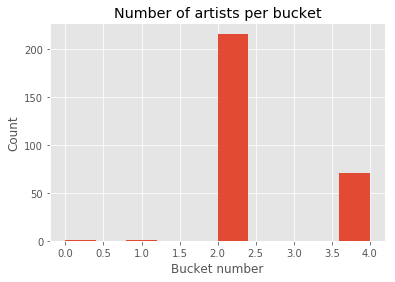

In [803]:
mylist = []
for artist in artist_assignments:
    mylist.append(artist_assignments[artist])

plt.title('Number of artists per bucket')
plt.xlabel('Bucket number')
plt.ylabel('Count')
plt.hist(mylist)

(array([  6.40000000e+01,   0.00000000e+00,   1.31000000e+02,
          0.00000000e+00,   0.00000000e+00,   6.85300000e+04,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.98910000e+04]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

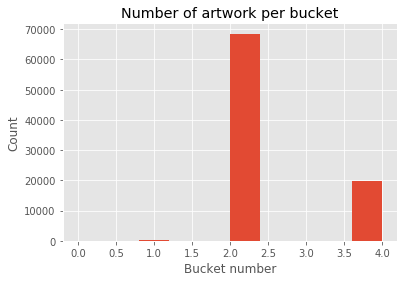

In [804]:
mylist = []
for artist in artist_assignments:
    mylist.append([artist_assignments[artist]]*len(artist_dict[artist]))
    
mylist = [item for sublist in mylist for item in sublist]


plt.title('Number of artwork per bucket')
plt.xlabel('Bucket number')
plt.ylabel('Count')
plt.hist(mylist)

Average nFavs for level 0 is [64.703125, 64.703125]
Average nFavs for level 1 is [85.389312977099237, 85.389312977099237]
Average nFavs for level 2 is [43.201951935828212, 34.358245122083169]
Average nFavs for level 3 is [nan, nan]
Average nFavs for level 4 is [269.14370890922737, 184.38028169014083]


/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


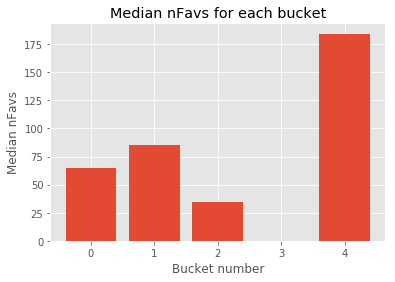

In [805]:
mylist = []
for artist in artist_assignments:
    artist_artwork = artist_dict[artist]
    artist_nfavs = [img_nfavs_dict[x] for x in artist_artwork]
    artist_bucket = artist_assignments[artist]
    mylist.append((artist_bucket, np.mean(artist_nfavs)))

grouped = []
for i in range(nExpertise):
    grouped.append([x for x in mylist if x[0] == i])

means = []
medians = []
for i in range(nExpertise):
    curr = grouped[i]
    try:
        curr_mean = np.mean([x[1] for x in curr])
        means.append(curr_mean)
    except:
        means.append(0)
        
    try:
        curr_median = np.median([x[1] for x in curr])
        medians.append(curr_median)
    except:
        medians.append(0)

    print("Average nFavs for level {} is {}".format(i, [curr_mean, curr_median]))
    
plt.bar(range(nExpertise), medians)
plt.title('Median nFavs for each bucket')
plt.xlabel('Bucket number')
plt.ylabel('Median nFavs')


In [692]:
level_uppers = []
static_beginners = []
static_experts = []
others = []

advancer_beginner = []
advancer_expert = []
advancer_inter = []


mostly_inter = []
inter_beginner = []
inter_expert = []
inter_inter = []



for artist in artist_assignments:
    vals = list(artist_assignments[artist].values())
    favs = list(img_nfavs_dict[x] for x in artist_assignments[artist].keys())

    intermediate_proportion = sum([1 for x in vals if x == 1])/len(vals)
        
    if intermediate_proportion > 0.5: #consider these to be intermediates
        mostly_inter.append(np.median(favs))
        inter_beginner.append(np.median([x[1] for x in zip(vals, favs) if x[0] == 0]))
        inter_inter.append(np.median([x[1] for x in zip(vals, favs) if x[0] == 1]))
        inter_expert.append(np.median([x[1] for x in zip(vals, favs) if x[0] == 2]))


        
    if 0 in vals and 1 in vals and 2 in vals: # and 3 in vals:
        level_uppers.append(np.median(favs))
        advancer_beginner.append(np.median([x[1] for x in zip(vals, favs) if x[0] == 0]))
        advancer_inter.append(np.median([x[1] for x in zip(vals, favs) if x[0] == 1]))
        advancer_expert.append(np.median([x[1] for x in zip(vals, favs) if x[0] == 2]))
    elif 0 in vals and not 2 in vals:
        static_beginners.append(np.median(favs))
    elif 2 in vals and not 0 in vals: # and not 3 in vals:
        static_experts.append(np.median(favs))
    else:
        others.append(np.median(favs))
        
print ("Average nFavs for static beginners and experts is {} and {} ({} and {} users) and for advancers \
is {} ({} users). For the rest it is {} ({} users)".format(
            np.mean(static_beginners), np.mean(static_experts), len(static_beginners), len(static_experts), 
            np.mean(level_uppers), len(level_uppers), np.mean(others), len(others)))

print ("\nFor advancers, their 0 artwork on average had median of {} nFavs; for level 1, {}, for level 2, {}".format(
            np.mean(advancer_beginner), np.mean(advancer_inter), np.mean(advancer_expert)))

print ("\nThere were {} mostly intermediate users, with an average median nFavs of {} ".format(
            len(mostly_inter), np.mean(mostly_inter)))

print ("Of these users, Level 0, 1, 2 had {}, {}, {} nFavs respectively, on average".format(
            np.nanmean(inter_beginner), np.mean(inter_inter), np.nanmean(inter_expert)))
print ("Level 1 advantage of Level 0 was {}, 2 over 1 was {}".format(
            np.nanmean(np.array(inter_inter)-np.array(inter_beginner)), 
            np.nanmean(np.array(inter_expert)-np.array(inter_inter))))

AttributeError: 'numpy.int64' object has no attribute 'values'

[[ 1.          0.40276712]
 [ 0.40276712  1.        ]]


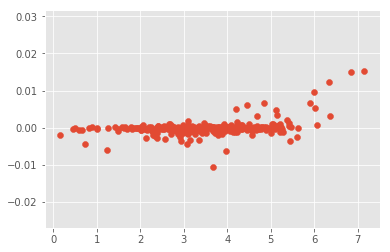

In [511]:
avg_per_artist = []
bias_for_artist = []

for artist in artist_assignments:
    avg_per_artist.append(np.mean([np.log(img_nfavs_dict[x]+0.001) for x in artist_dict[artist]]))
    bias_for_artist.append(artist_bias[artist])
print(np.corrcoef(avg_per_artist, bias_for_artist))
plt.scatter(avg_per_artist, bias_for_artist)


In [408]:
props = []

for artist in artist_assignments:

    values = artist_assignments[artist].values()
    num = 0
    for i in range(nExpertise):
        curr = len([x for x in values if x==i])
        if curr > num: num = curr
    props.append(float(num)/len(values))
    
print('Median is {}; mean is {}'.format(np.median(props), np.mean(props)))



Median is 0.9573643410852714; mean is 0.8510968690366506


In [409]:
AUC(data, valid, item_biases, latent_items, latent_users, visual_users, E, visual_bias, dd_bias, artist_bias)

0.89800801021081822

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


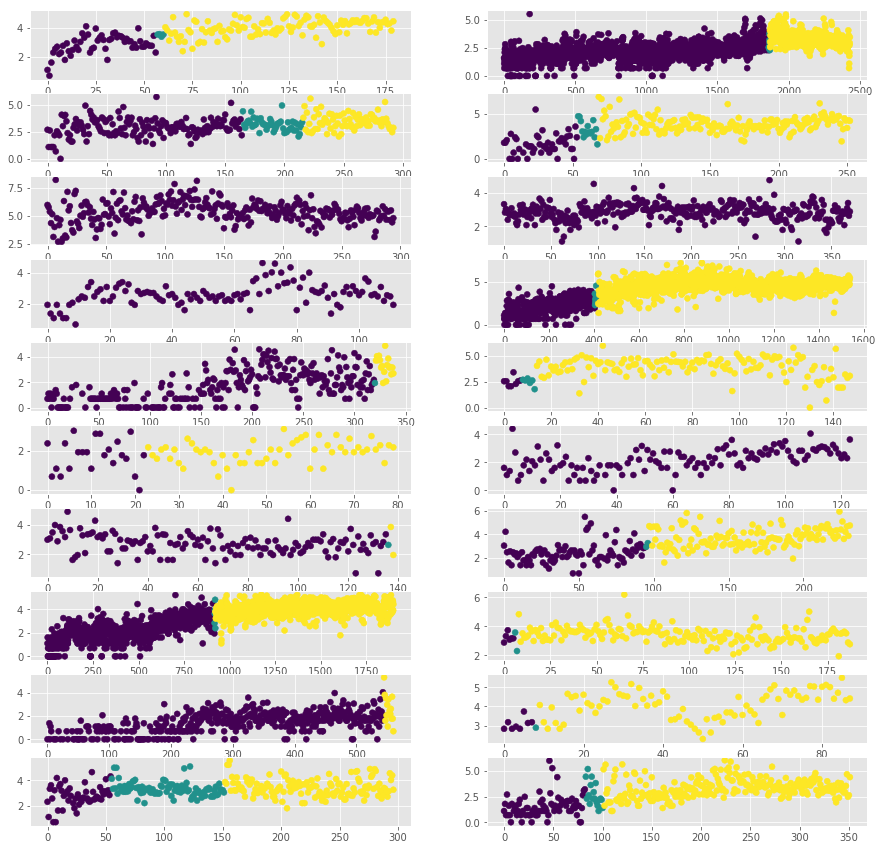

In [410]:
i = 0 
fig, axes = plt.subplots(nrows=10, ncols=2, figsize = (15,15))
keys = list(artist_assignments.keys())
np.random.shuffle(keys)
for artist in keys:
    curr_assignments = artist_assignments[artist]
    vals = list(curr_assignments.values())
    if True: # 0 in vals and 1 in vals and 2 in vals and 3 in vals:
        x = artist_dict[artist]
        ratings = [(img_nfavs_dict[img]) for img in x]
        y = [np.log(img_nfavs_dict[img]) for img in x]
        devs = [dd_dict[img] for img in x]


        axes[i%10, int(i/10)].scatter(range(len(y)), y, c=vals)
        i += 1
        if i == 20: break


In [789]:
def train_AUC(data, valid, item_biases, latent_items, latent_users, visual_users, E, E_delta, visual_bias, vb_delta, dd_bias, artist_bias, samples):

    auc2 = 0.0
    auc = 0.0
    #samples = sample_triple(data, valid, 1000000)
    for user, rated_item, unrated_item in tqdm(samples):

        # Extract out the relevant variables
        rated_item_bias = item_biases[rated_item]
        unrated_item_bias = item_biases[unrated_item]
        latent_user = latent_users[user]
        latent_rated_item = latent_items[rated_item]
        latent_unrated_item = latent_items[unrated_item]

        visual_user = visual_users[user]
        rated_vf = visual_data[rated_item]
        unrated_vf = visual_data[unrated_item]
        
        rated_artist = item_to_artist[rated_item]
        unrated_artist = item_to_artist[unrated_item]
        
        rated_expertise_level = artist_assignments[rated_artist]
        unrated_expertise_level = artist_assignments[unrated_artist]
        rated_E = E+E_delta[:,:,rated_expertise_level]
        unrated_E = E+E_delta[:,:,unrated_expertise_level]
        
        rated_visual_bias = visual_bias+vb_delta[:,rated_expertise_level]
        unrated_visual_bias = visual_bias+vb_delta[:,unrated_expertise_level]
        
        dd_diff = dd_dict[rated_item]*dd_bias[rated_expertise_level]-\
                dd_dict[unrated_item]*dd_bias[unrated_expertise_level]
            
        artist_diff = artist_bias[rated_artist] - artist_bias[unrated_artist]
        
        '''cat_bias_diff = categorical_bias[cat_dict[rated_item]]-\
                        categorical_bias[cat_dict[unrated_item]]'''

        
        # Determine the output, i.e. x_uij 
        br_opt = BR_opt(rated_item_bias, unrated_item_bias, latent_user, latent_rated_item, latent_unrated_item,
                        rated_vf, unrated_vf,
                        rated_E, unrated_E, rated_visual_bias, unrated_visual_bias, visual_user, dd_diff,
                         artist_diff)#, cat_bias_diff)
        
        auc += (br_opt > 0)
        auc2 += br_opt
    return (auc/len(samples), auc2/len(samples))